<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports</a></span><ul class="toc-item"><li><span><a href="#Librairies" data-toc-modified-id="Librairies-0.1.1"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Librairies</a></span></li><li><span><a href="#Données" data-toc-modified-id="Données-0.1.2"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>Données</a></span></li></ul></li></ul></li><li><span><a href="#Entraînement-du-modèle" data-toc-modified-id="Entraînement-du-modèle-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Entraînement du modèle</a></span><ul class="toc-item"><li><span><a href="#Fonctions" data-toc-modified-id="Fonctions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fonctions</a></span></li><li><span><a href="#Boucle-d'entraînement" data-toc-modified-id="Boucle-d'entraînement-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Boucle d'entraînement</a></span><ul class="toc-item"><li><span><a href="#Descente-de-gradient-batch" data-toc-modified-id="Descente-de-gradient-batch-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Descente de gradient batch</a></span></li><li><span><a href="#Descente-de-gradient-stochastique" data-toc-modified-id="Descente-de-gradient-stochastique-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Descente de gradient stochastique</a></span></li><li><span><a href="#Descente-de-gradient-mini-batch" data-toc-modified-id="Descente-de-gradient-mini-batch-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Descente de gradient mini-batch</a></span></li></ul></li></ul></li><li><span><a href="#Avec-le-module-Pytorch" data-toc-modified-id="Avec-le-module-Pytorch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Avec le module Pytorch</a></span><ul class="toc-item"><li><span><a href="#Avec-optim" data-toc-modified-id="Avec-optim-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Avec optim</a></span></li><li><span><a href="#Avec-sequential" data-toc-modified-id="Avec-sequential-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Avec sequential</a></span></li></ul></li></ul></div>

## Imports

### Librairies

In [352]:
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
## Installer datamaestro et datamaestro-ml pip install datamaestro datamaestro-ml
import datamaestro
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt

### Données

On importe les données, puis on sépare en fonction de l'entrée et la sortie. Enfin, on sépare le dataset en train et test.

In [528]:
data=datamaestro.prepare_dataset("edu.uci.boston")

In [529]:
colnames, datax, datay = data.data()
datax = torch.tensor(datax,dtype=torch.float64, requires_grad=True)
datay = torch.tensor(datay,dtype=torch.float64, requires_grad=True).reshape(-1,1)

In [530]:
trainx = datax[:int(len(datax)*0.8)]
trainy = datay[:int(len(datax)*0.8)]

testx = datax[int(len(datax)*0.8):]
testy = datay[int(len(datax)*0.8):]

In [531]:
with torch.no_grad():
    moy_x = torch.mean(trainx, 0)
    ec_type_x = torch.std(trainx, 0)
    moy_x = moy_x.unsqueeze(0).expand_as(trainx)
    ec_type_x = ec_type_x.unsqueeze(0).expand_as(trainx)
    trainx = (trainx-moy_x)/ec_type_x

In [532]:
with torch.no_grad():
    moy_y = torch.mean(trainy, 0)
    ec_type_y = torch.std(trainy, 0)
    moy_y = moy_y.unsqueeze(0).expand_as(trainy)
    ec_type_y = ec_type_y.unsqueeze(0).expand_as(trainy)
    trainy = (trainy-moy_y)/ec_type_y

In [533]:
print(trainx.shape, trainy.shape, testx.shape, testy.shape)

torch.Size([404, 13]) torch.Size([404, 1]) torch.Size([102, 13]) torch.Size([102, 1])


In [534]:
with torch.no_grad():
    testx = (trainx - moy_x)/ec_type_x
    testy = (trainy - moy_y)/ec_type_y

# Entraînement du modèle

## Fonctions

On n'a besoin que de deux fonctions pour l'entraînement : l'inférence en fonction de ``x``, et le MSE en fonction du ``y_hat`` calculé. Contrairement au TME précédent, on ne calcule pas "à la main" le gradient, puisque Pytorch le permet directement.

In [535]:
def linear_forward(x, w, b):
    y = torch.matmul(x, torch.transpose(w, 0, 1))
    y += b.expand_as(y)                   
    return y

In [536]:
def MSE_forward(y_hat, y_true):
    return torch.sum((y_hat - y_true)**2)/len(y_hat)

## Boucle d'entraînement

In [598]:
num_train = len(trainx)
maxiter = 200 # Les paramètres du modèle à optimiser 
epsilon = 1e-1

In [599]:
weight = torch.randn(1,13, requires_grad=True, dtype=torch.float64).double()
bias = torch.randn(1, requires_grad=True, dtype=torch.float64) 

In [600]:
writer = SummaryWriter('C:\Mathilde\Classe\Jussieu\AMAL\TP2')

### Descente de gradient batch

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1078.15it/s]


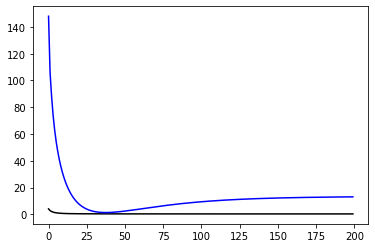

In [601]:
testError = [] 
trainError = []
for n_iter in tqdm(range(maxiter)):                               #Boucle des epochs
    
    y_hat = linear_forward(trainx, weight, bias)                  #On calcule le forward pass du perceptron 
                                                                  #sur tout le train set
    loss = MSE_forward(y_hat, trainy)                             #On calcule le MSE obtenu
    y_hat.retain_grad()                                           #On sauvegarde les gradients désirés
    loss.backward() 

    with torch.no_grad():                                         #On actualise les poids, sans en calculer le gradient
        weight -= epsilon*weight.grad
        bias -= epsilon*bias.grad

    weight.grad.data.zero_()                                      #On remet les gradients à 0
    bias.grad.data.zero_() 
    
    #Tous les batchs ont maintenant été utilisés une fois
    with torch.no_grad():                                         #On teste les poids nouvellement calculés
        y_hat_test = linear_forward(testx, weight, bias) 
        loss_test = MSE_forward(y_hat_test, testy)
        y_hat = linear_forward(trainx, weight, bias) 
        loss = MSE_forward(y_hat, trainy)
    
    writer.add_scalar('Loss/train', loss_test, n_iter)
    trainError.append(loss)    
    testError.append(loss_test) 
plt.plot(trainError, 'black')
plt.plot(testError, 'blue')

In [560]:
writer.close()

### Descente de gradient stochastique

In [586]:
num_train = len(trainx)
maxiter = 200 # Les paramètres du modèle à optimiser 
epsilon = 1e-4

In [587]:
weight_stoch = torch.randn(1,13, requires_grad=True, dtype=torch.float64).double()
bias_stoch = torch.randn(1, requires_grad=True, dtype=torch.float64) 

In [588]:
writer = SummaryWriter('C:\Mathilde\Classe\Jussieu\AMAL\TP2')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:21<00:00,  9.44it/s]


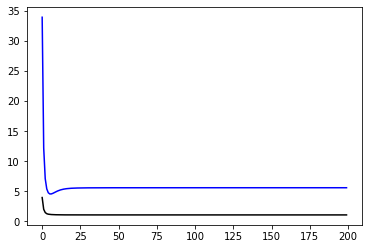

In [589]:
testError_stoch = [] 
trainError_stoch = []
for n_iter in tqdm(range(maxiter)):                                     #Boucle des epochs
    
    for i in range(num_train):                                          #Boucle des unités
            
        y_hat = linear_forward(trainx[i], weight_stoch, bias_stoch)     #On calcule le forward pass du perceptron
        loss = MSE_forward(y_hat, batchy)                               #On calcule le MSE obtenu
        y_hat.retain_grad()                                             #On sauvegarde les gradients désirés
        loss.backward() 
        
        with torch.no_grad():                                           #On actualise les poids, 
                                                                        #sans en calculer le gradient
            weight_stoch -= epsilon*weight_stoch.grad
            bias_stoch -= epsilon*bias_stoch.grad
            
        weight_stoch.grad.data.zero_()                                  #On remet les gradients à 0
        bias_stoch.grad.data.zero_() 
    
    #Tous les batchs ont maintenant été utilisés une fois
    with torch.no_grad():                                              #On teste les poids nouvellement calculés
        y_hat_test = linear_forward(testx, weight_stoch, bias_stoch) 
        loss_test = MSE_forward(y_hat_test, testy)
        y_hat = linear_forward(trainx, weight_stoch, bias_stoch) 
        loss = MSE_forward(y_hat, trainy)
    
    writer.add_scalar('Loss/train', loss_test, n_iter)
    trainError_stoch.append(loss)    
    testError_stoch.append(loss_test) 
plt.plot(trainError_stoch, 'black')
plt.plot(testError_stoch, 'blue')

In [575]:
writer.close()

### Descente de gradient mini-batch

In [581]:
num_train = len(trainx)
maxiter = 200 # Les paramètres du modèle à optimiser 
epsilon = 1e-2

In [582]:
weight_batch = torch.randn(1,13, requires_grad=True, dtype=torch.float64).double()
bias_batch = torch.randn(1, requires_grad=True, dtype=torch.float64) 

In [583]:
writer = SummaryWriter('C:\Mathilde\Classe\Jussieu\AMAL\TP2')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.41it/s]


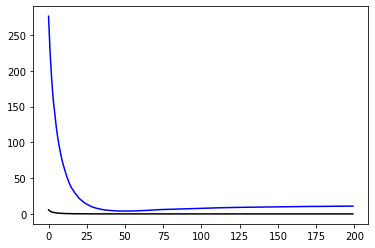

In [584]:
testError_batch = [] 
trainError_batch = []
for n_iter in tqdm(range(maxiter)):                                #Boucle des epochs
    epsilon *= 0.99
    liste = [i for i in range(num_train)]                          #On mélange les données d'entraînement
    shuffle(liste)
    
    for i in range(int(num_train/32) + 1):                         #Boucle des batch
        index = liste[i * 32: (i+1) * 32]                          #On crée le batch en fonction du mélange déterminé
        with torch.no_grad():
            batchx = trainx[index[0]].unsqueeze(0)
            batchy = trainy[index[0]].unsqueeze(0)    
        for j in index[1:]:
            batchx = torch.cat((batchx, trainx[j].unsqueeze(0)))
            batchy = torch.cat((batchy, trainy[j].unsqueeze(0)))
            
        y_hat = linear_forward(batchx, weight_batch, bias_batch)              #On calcule le forward pass du perceptron
        loss = MSE_forward(y_hat, batchy)                         #On calcule le MSE obtenu
        y_hat.retain_grad()                                       #On sauvegarde les gradients désirés
        loss.backward() 
        
        with torch.no_grad():                                     #On actualise les poids, sans en calculer le gradient
            weight_batch -= epsilon*weight_batch.grad
            bias_batch -= epsilon*bias_batch.grad
            
        weight_batch.grad.data.zero_()                                  #On remet les gradients à 0
        bias_batch.grad.data.zero_() 
    
    #Tous les batchs ont maintenant été utilisés une fois
    with torch.no_grad():                                         #On teste les poids nouvellement calculés
        y_hat_test = linear_forward(testx, weight_batch, bias_batch) 
        loss_test = MSE_forward(y_hat_test, testy)
        y_hat = linear_forward(trainx, weight_batch, bias_batch) 
        loss = MSE_forward(y_hat, trainy)
    
    writer.add_scalar('Loss/train', loss_test, n_iter)
    trainError_batch.append(loss)    
    testError_batch.append(loss_test) 
plt.plot(trainError_batch, 'black')
plt.plot(testError_batch, 'blue')

In [585]:
writer.close()

# Avec le module Pytorch

## Avec optim

In [670]:
errorTrain=[]
errorTest=[]

linear_forward1 = torch.nn.Linear(13,4)
tanh_forward = torch.nn.Tanh()
linear_forward2 = torch.nn.Linear(4,1)
mse_forward = torch.nn.MSELoss()

param = list(linear_forward1.parameters()) + list(linear_forward2.parameters())

optim = torch.optim.SGD(params=param,lr=0.03) ## on optimise selon w et b, lr : pas de gradient
optim.zero_grad()

for i in range(500):
    output = linear_forward2(tanh_forward(linear_forward1(trainx.float())))
    loss = mse_forward(output,trainy.float()) #Calcul du cout
    loss.backward() # Retropropagation
    if i % 10 == 0:
        errorTrain.append(loss)
        optim.step() # Mise-à-jour des paramètres w et b
        optim.zero_grad() # Reinitialisation du gradient
        with torch.no_grad():                                         #On teste les poids nouvellement calculés
            y_hat_test = linear_forward2(tanh_forward(linear_forward1(testx.float()))) 
            loss_test = mse_forward(y_hat_test, testy.float())
            errorTest.append(loss_test)

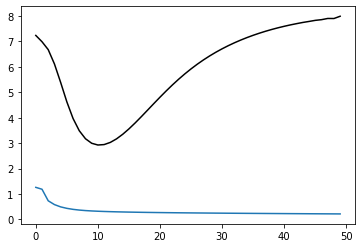

In [671]:
plt.plot(errorTrain)
plt.plot(errorTest, 'black')

## Avec sequential

In [693]:
errorTrain=[]
errorTest=[]

model = torch.nn.Sequential(
    torch.nn.Linear(13, 404),
    torch.nn.Tanh(),
    torch.nn.Linear(404, 1),
)

loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 0.00006
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(500):
    y_pred = model(trainx.float())

    loss = loss_fn(y_pred, trainy.float())
    if t % 10 == 0:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        errorTrain.append(loss)
        with torch.no_grad():                                         #On teste les poids nouvellement calculés
            y_hat_test = model(testx.float())
            loss_test = loss_fn(y_hat_test, testy.float())
            errorTest.append(loss_test)

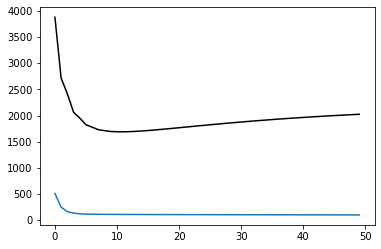

In [694]:
plt.plot(errorTrain)
plt.plot(errorTest, 'black')